Myopic deconvolution algorithm from

Thibon, Louis, Ferréol Soulez, and Éric Thiébaut. _Fast automatic
myopic deconvolution of angiogram sequence_. In International
Symposium on Biomedical Imaging. Beijing, China, 2014. https://hal.archives-ouvertes.fr/hal-00914846.



In [89]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from skimage.io import imread
from skimage import img_as_float
from auto_metro.myopic_deconv import MODE_NAMES, zernike_tf, deconvolution, power_law
from auto_metro.utils import _fft, _ifft, apodise
from scipy.optimize import minimize

mpl.rcParams['figure.figsize'] = (12, 9)

In [90]:

def show_results(image, params, modes, fft_window=20):
    
    amps = [params[mode] for mode in modes]
    mode_names = [MODE_NAMES[mode].replace(' ', '\n') for mode in modes]

    nx, ny = image.shape
    xx, yy = np.meshgrid(np.linspace(-1, 1, ny), np.linspace(-1, 1, nx))
    rho = (xx ** 2 + yy ** 2) ** 0.5
    phi = np.arctan2(yy, xx)
    win = 20

    tf = zernike_tf(rho, phi, pupil, amps, modes)
    psf = _ifft(tf)

    fig, axes = plt.subplots(2, 2)
    axes[0, 0].imshow(image)
    axes[0, 0].set_title("input")

    axes[0, 1].imshow(np.abs(tf))
    axes[0, 1].set_title("wavefront")

    axes[1, 1].imshow(np.abs(psf)[
        nx//2-win: nx//2+win,
        ny//2-win: ny//2+win
    ])
    axes[1, 1].set_title("FFT")

    axes[1, 0].set_title("Zernike amplitudes")
    axes[1, 0].set_xlabel('Mode amplitude')

    axes[1, 0].barh(np.arange(len(amps)), amps)
    axes[1, 0].set_yticks(np.arange(len(amps)))
    axes[1, 0].set_yticklabels(mode_names);
    return axes, fig


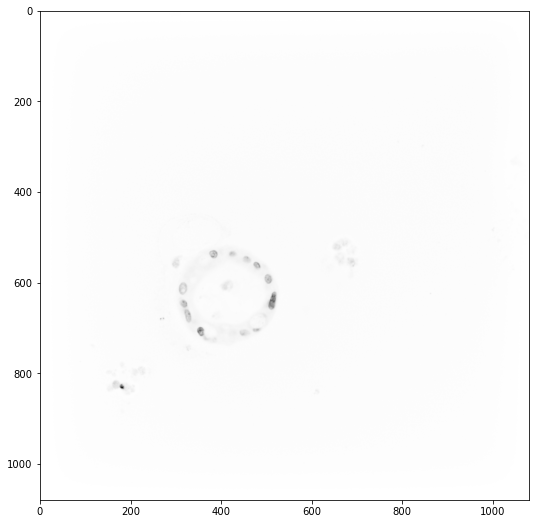

In [91]:
image = img_as_float(imread("../../samples/organo.tiff"))
image = apodise(image, 60)
nx, ny = image.shape

plt.imshow(image, cmap='Greys')

In [92]:
from scipy.fft import fftn, fftshift

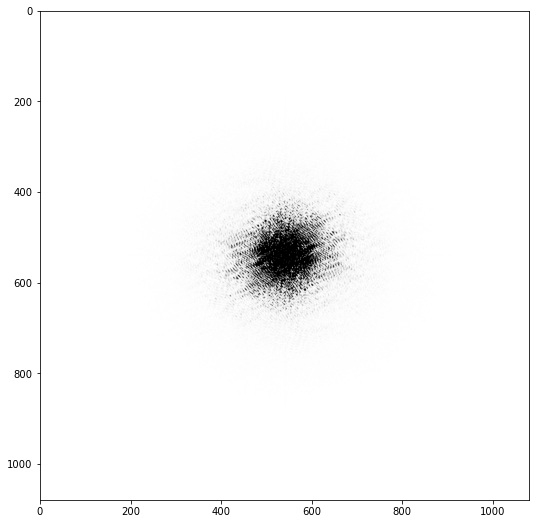

In [93]:
plt.imshow((np.abs(fftshift(fftn(fftshift(image))**2)).clip(0, 100)), cmap="Greys")

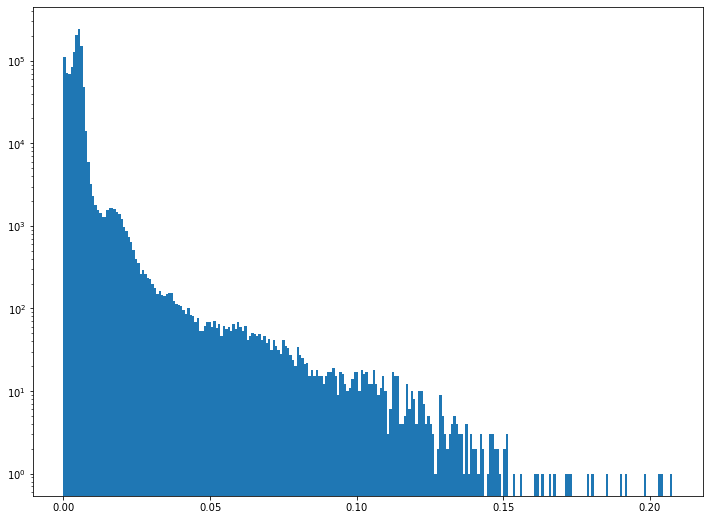

In [94]:
fig, ax = plt.subplots()
h = ax.hist(image.ravel(), bins=256)
ax.set_yscale('log')

In [95]:
modes = [(2, -2), (2, 2), (4, 0)]
initial_guess = {
    "alpha": -2,
    "beta": 2.,
    "resolution": 10.0
}
initial_guess.update({mode:1e-4 for mode in modes})
params, costs = deconvolution(
    image,
    modes=modes,
    initial_guess=initial_guess,
    method="Nelder-Mead",
    options={"xtol": 1e-8, "maxiter": 500},
)
print(f'α : {params["alpha"]:.3e}')
print(f'β : {params["beta"]:.3e}')
print(f'resolution : {params["resolution"]:.3e}')
pupil = params["resolution"] / np.pi
for mode in modes:
    print(f"{MODE_NAMES[mode]}: {params[mode]: .3e}")


α : -1.414e+01
β : -6.483e-11
resolution : 6.397e+00
Oblique astigmatism: -7.859e-04
Vertical astigmatism:  1.656e-04
Primary Spherical:  4.001e-05


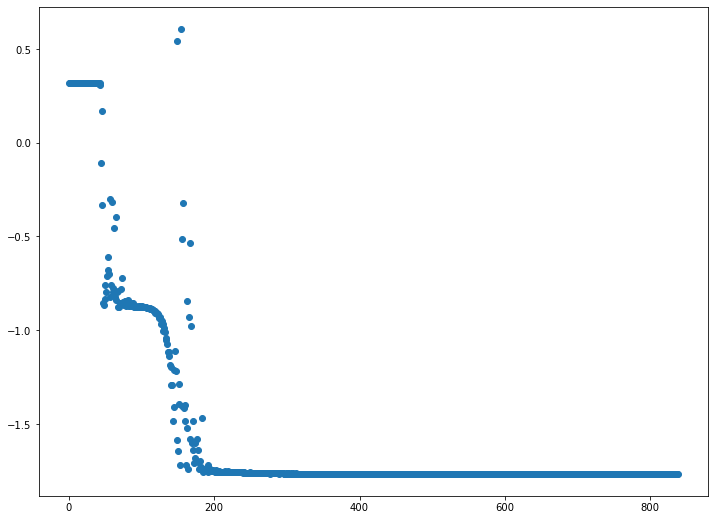

In [96]:
plt.plot(np.log10(costs), 'o')

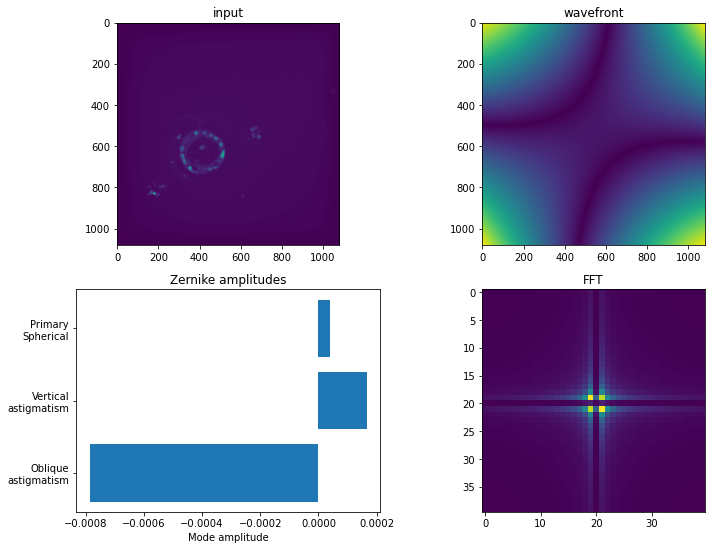

In [97]:
fig, axes = show_results(image, params, modes)


In [101]:
modes = [(2, -2), (2, 2), (4, 0)]
params_T, costs = deconvolution(
    image.swapaxes(0, 1),
    modes=modes,
    initial_guess=params_T,
    method="Nelder-Mead",
    options={"xtol": 1e-8},
)


print(f'α : {params_T["alpha"]:.3e}')
print(f'β : {params_T["beta"]:.3e}')
print(f'resolution : {params_T["resolution"]:.3e}')
pupil = params_T["resolution"] / np.pi
for mode in modes:
    print(f"{MODE_NAMES[mode]}: {params_T[mode]: .3e}")


α : -1.415e+01
β : -8.915e-10
resolution : 6.397e+00
Oblique astigmatism:  2.105e-02
Vertical astigmatism: -6.488e-06
Primary Spherical: -3.734e-04


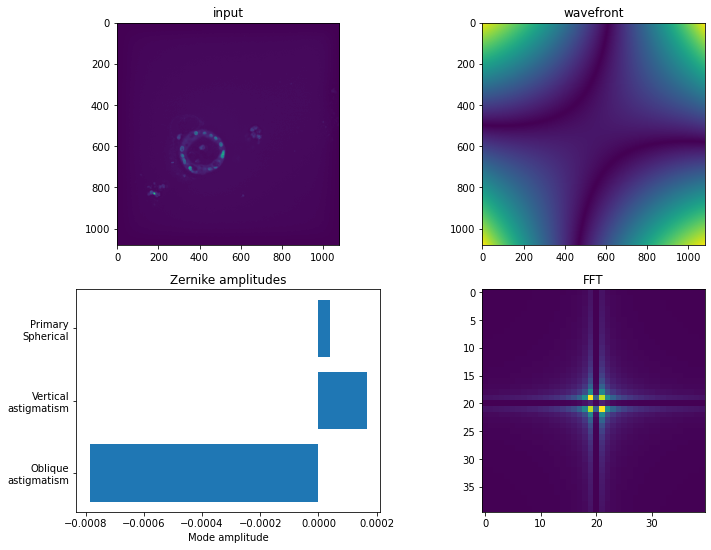

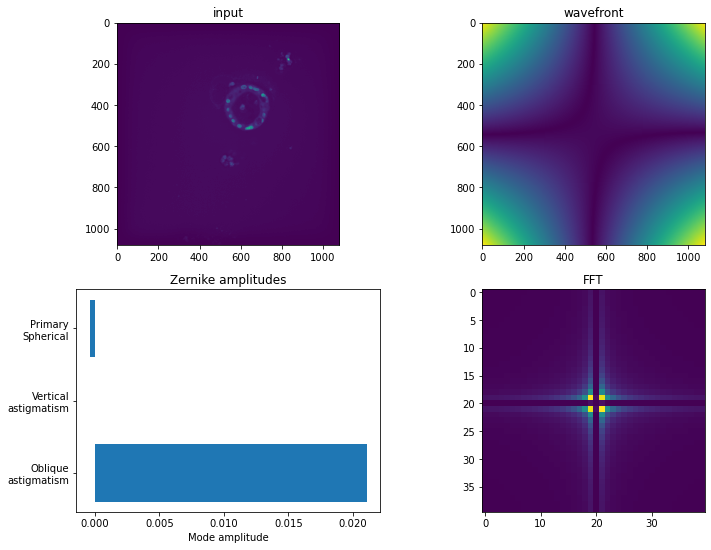

In [102]:
fig, axes = show_results(image, params, modes)
fig, axes = show_results(image.T, params_T, modes)

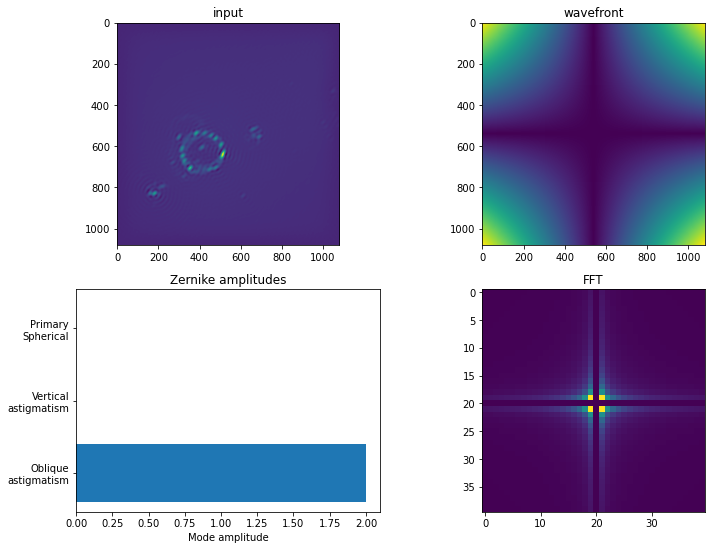

In [111]:
nx, ny = image.shape
xx, yy = np.meshgrid(np.linspace(-1, 1, ny), np.linspace(-1, 1, nx))
rho = (xx ** 2 + yy ** 2) ** 0.5
phi = np.arctan2(yy, xx)

tf_astigmatic = zernike_tf(rho, phi, 30, [1.0, 2.0, 0.0, 0.0], [(0, 0)] + modes)
in_params = {
    "alpha": 1.,
    "beta": 2.,
    "resolution": 300.,
    (2, -2): 2.0,
    (2, 2): 0.0,
    (4, 0): 0.0,
}
im_fft = _fft(image)
#im_fft /= np.abs(im_fft).sum()
image_astigm = np.real(_ifft(im_fft * tf_astigmatic))

fig, axes = show_results(image_astigm, in_params, modes)

In [104]:
params_as, costs = deconvolution(
    image_astigm.T,
    modes=modes,
    initial_guess=params,
    method="Nelder-Mead",
    options={"xtol": 1e-8},
)

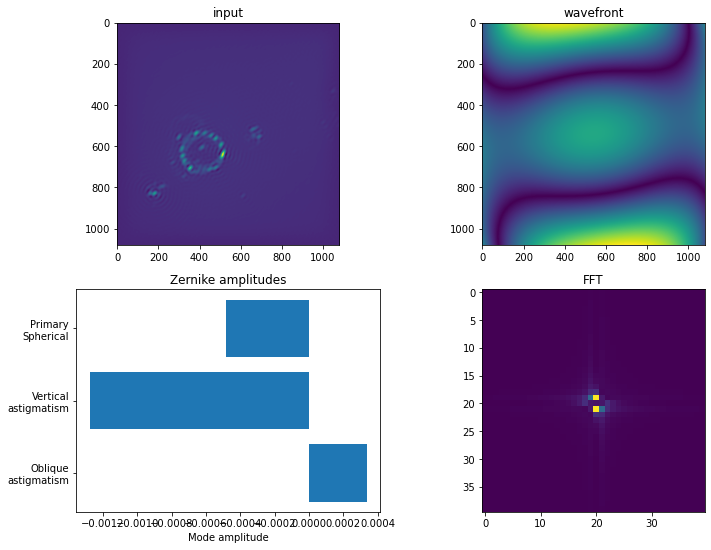

In [105]:
fig, axes = show_results(image_astigm, params_as, modes)

In [ ]:
import javabridge
import bioformats
javabridge.start_vm(class_path=bioformats.JARS)

# your program goes here

javabridge.kill_vm()
